# Bose-Bose Droplets: critical atom number study


# Import dependencies

In [472]:

import numpy as np
import random
from numpy import loadtxt
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt

import scipy.special
from scipy.optimize import fmin


# Write function to determine $n_c$

In [473]:

import numpy as np



def en_per_particle(sigma_r, nparticles, alpha, beta, gamma, a_11, a_ho):
    sigma_z = a_ho / a_11
    N = nparticles
    
    en_kin = 1./sigma_r**2 # + 0.5/sigma_z**2
    en_trap = N*sigma_z**2/(2*(a_ho/a_11)**4) 
    en_alpha = np.sqrt(2)*N**2*alpha/(4*np.pi**1.5*sigma_r**2*sigma_z)
    en_lhy = N*beta*(N/(np.pi**1.5*sigma_r**2*sigma_z))**gamma/(gamma + 1)**(3/2)

    
    return en_kin  + en_alpha/N + en_lhy/N # + en_trap/N


def local_minima(array1d):
    # find local minima in 1d array.
    # Returns array of indices of local minima
    # True if the point is a local minimum
    return ((array1d <= np.roll(array1d,  1)) &
            (array1d <= np.roll(array1d, -1)))
    

def estimate_nc(alpha, beta, gamma, a_11, a_ho, verbose=True):
    # Critical atom number is the number of atoms for which the energy of a system crosses zero.
    # The energy of a system is given by the second element of the tuple returned by en_particles.
    # The first element of the tuple is the optimal x_0.
    # Implement the root-finding algorithm to find the critical atom number
    # The function should return the critical atom number and the optimal x_0 for that atom number
    # The function should also return the energy of the system for the critical atom number.
    
    # set initial atom number
    nparticles = 30_000


    iter_num = 0
    ng = 10_000
    sr_range = np.linspace(0.1, 100, ng) * a_ho / a_11
    
    # Calculate the critical atom number in the following way:
    # 1. Find if there is a local minima of the energy for a given number of atoms
    # 2. if there exists local minimum, decrease the number of atoms. If not, break the loop
    while True:
        en_0 = en_per_particle(sr_range, nparticles, alpha, beta, gamma, a_11, a_ho)
        local_min = local_minima(en_0)
        
        # if there exists local minimum, decrease the number of atoms. If not, break the loop
        if np.sum(local_min) > 0:
            nparticles_new = nparticles * 0.99
            nparticles = nparticles_new
            
            # print the sr and sz values for the local minima
            sr_local_min = sr_range[local_min]
            if verbose == True:
                print(f"nparticles: {nparticles}, sr_local_min: {sr_local_min}")
            
            if np.min(en_0) > 0 and np.min(sr_local_min) > sr_range[-2]:
                break
            
            iter_num += 1
            if iter_num > 4000 or nparticles < 10:
                # Raise value error
                print("Too many iterations")
                return 0, 0
                # raise ValueError("Too many iterations")
                # break the while loop
                break
        else:
            break

    return nparticles, np.min(en_0)

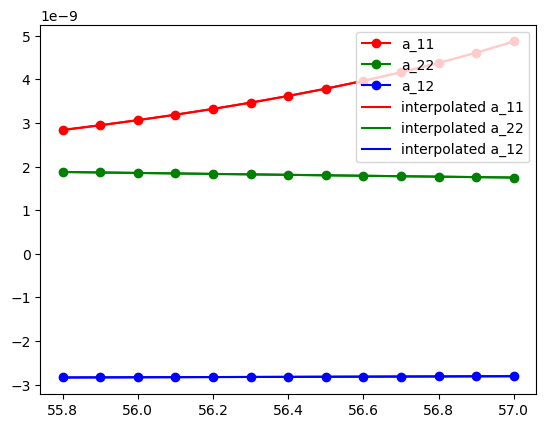

In [474]:
a_ho = 0.639E-06 # in metres
bohr_radius = 5.2917721067E-11 # in metres
# read 39K_are.txt file into a numpy array
data = np.loadtxt("39K_are.txt")
# Columns are in the following format: B, a_11, reff_11, a_22, reff_22, a_12, reff_12. Load the data into the following variables
B_data = data[:, 0]
a_11 = data[:, 1] * bohr_radius
a_22 = data[:, 3] * bohr_radius
a_12 = data[:, 5] * bohr_radius
# Create functions that interpolates the data for a given magnetic field
def interpolate_a11(B):
    return np.interp(B, B_data, a_11)

def interpolate_a22(B):
    return np.interp(B, B_data, a_22)

def interpolate_a12(B):
    return np.interp(B, B_data, a_12)

# Visualize the data and the interpolation functions
plt.plot(B_data, a_11, label="a_11", marker='o', color='r')
plt.plot(B_data, a_22, label="a_22", marker='o', color='g')
plt.plot(B_data, a_12, label="a_12", marker='o', color='b')
plt.plot(B_data, interpolate_a11(B_data), label="interpolated a_11", color='r')
plt.plot(B_data, interpolate_a22(B_data), label="interpolated a_22", color='g')
plt.plot(B_data, interpolate_a12(B_data), label="interpolated a_12", color='b')
# put legend
plt.legend()

In [475]:
def get_mflhy_params(a_11, a_22, a_12):
    alpha = 4*np.pi*(1.+1 + 2*1*(a_12/a_11)/np.sqrt(a_22/a_11))/np.power(1 + 1/np.sqrt(a_22/a_11), 2);
    beta  = (512*np.sqrt(np.pi)/15)*np.power((1+1*np.sqrt(a_22/a_11)) / (1+1/np.sqrt(a_22/a_11)), 5./2);
    return alpha, beta


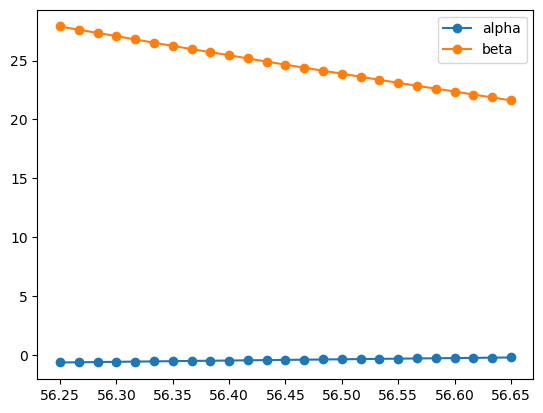

In [476]:
# make a linspace of B values between 56.25 and 56.65
B_range = np.linspace(56.25, 56.65, 25)
# For each point in the B_range, calculate the alpha and beta parameters
alpha = np.zeros_like(B_range)
beta = np.zeros_like(B_range)
gamma = 1.5
for i, B in enumerate(B_range):
    alpha[i], beta[i] = get_mflhy_params(interpolate_a11(B), interpolate_a22(B), interpolate_a12(B))
# Plot the alpha and beta parameters as a function of B
plt.plot(B_range, alpha, label="alpha", marker='o')
plt.plot(B_range, beta, label="beta", marker='o')
plt.legend()

a_11: 3.788757680906459e-09, a_22: 0.47546353377198075, a_12: -0.744607424903131
alpha: -0.33432412538479594, beta: 23.886370017169355


(-2.1568699523049217e-08, 2.1568699523049217e-08)

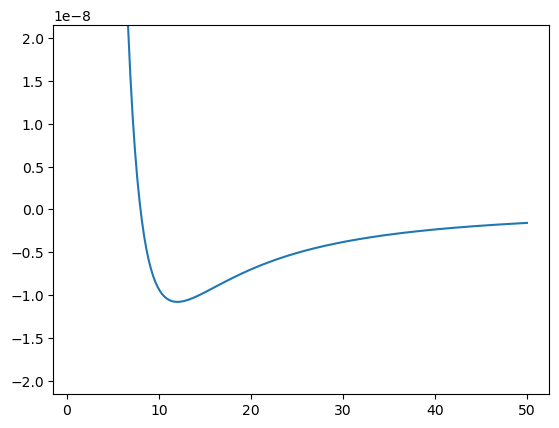

In [477]:
# For a magnetic field of 56.5 T, plot the energy of the system as a function of sigma_r, for N = 9_000. You'll see that the energy has a local minimum, and that sigma_r corresponding to the local minimum is the optimal value of sigma_r.
B = 56.5
alpha, beta = get_mflhy_params(interpolate_a11(B), interpolate_a22(B), interpolate_a12(B))
# print a_11, a_22, a_12
print(f"a_11: {interpolate_a11(B)}, a_22: {interpolate_a22(B)/interpolate_a11(B)}, a_12: {interpolate_a12(B)/interpolate_a11(B)}")
# print alpha and beta
print(f"alpha: {alpha}, beta: {beta}")
sr_range = np.linspace(1, 50, 200) * a_ho / interpolate_a11(B)
en_0 = en_per_particle(sr_range, 9_000, alpha, beta, 1.5, interpolate_a11(B), a_ho)
plt.plot(sr_range / (a_ho / interpolate_a11(B)), en_0, label="Energy")
# set the y limit to be between -0.1 and 0.1
# what is min and max of en_0?
np.min(en_0)
# set ylim to be between 2*min and 2*abs(min)
plt.ylim(2*np.min(en_0), 2*np.abs(np.min(en_0)))

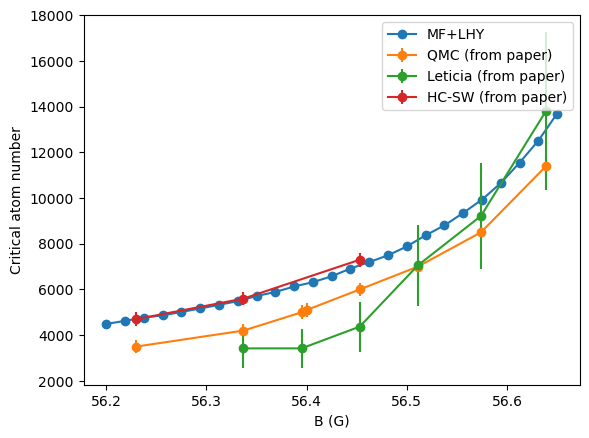

In [478]:
# set B_range to be between 56.2 and 56.65
B_range = np.linspace(56.2, 56.65, 25)
# For each point in the B_range, calculate the critical atom number 
nparticles = np.zeros_like(B_range)
en_0 = np.zeros_like(B_range)
for i, B in enumerate(B_range):
    # get alpha and beta
    alpha, beta = get_mflhy_params(interpolate_a11(B), interpolate_a22(B), interpolate_a12(B))    
    nparticles[i], en_0[i] = estimate_nc(alpha, beta, gamma, interpolate_a11(B), a_ho)
# Plot the critical atom number as a function of B  
plt.plot(B_range, nparticles, label="MF+LHY", marker='o')
# ylabel is "Critical atom number" and xlabel is "B (G)"
plt.ylabel("Critical atom number")
plt.xlabel("B (G)")

# Load data fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat from the ./data-from-paper/ folder
data_qmc = np.loadtxt("./data-from-paper/fig3a_qmc.dat")
data_let = np.loadtxt("./data-from-paper/fig3a_data_leticia.dat")
data_hcsw = np.loadtxt("./data-from-paper/fig3a_qmc_hcsw.dat")
# Plot the data from fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat. 0th column is B, 1st column is nparticles, 2nd column is error. In case of fig3a_data_leticia.dat, 2nd column is nparticles, 3rd column is error.
plt.errorbar(data_qmc[:,0], data_qmc[:,1], yerr=data_qmc[:,2], label="QMC (from paper)", marker='o')
plt.errorbar(data_let[:,0], data_let[:,2], yerr=data_let[:,3], label="Leticia (from paper)", marker='o')
plt.errorbar(data_hcsw[:,0], data_hcsw[:,1], yerr=data_hcsw[:,2], label="HC-SW (from paper)", marker='o')

plt.legend()

Ok, so this is how a figure from the paper is generated. Now let's do the following: Let's

rho: [1.e-05 2.e-05 3.e-05 4.e-05 5.e-05 6.e-05 7.e-05 8.e-05 9.e-05 1.e-04], en: [-1.260085e-06 -1.968730e-06 -2.371282e-06 -2.462690e-06 -2.382239e-06
 -2.036552e-06 -1.548057e-06 -8.673761e-07 -1.244487e-07  7.746036e-07], sigma_en: [5.058807e-09 7.422552e-09 1.302559e-08 1.511843e-08 1.970012e-08
 2.844823e-08 2.198545e-08 1.590390e-08 2.195948e-08 4.582702e-08]
[alpha, beta, gamma] = [-0.20277524186653187, 12.151575557954605, 1.4399628174001278]
Critical atom number: 12388.490134016645


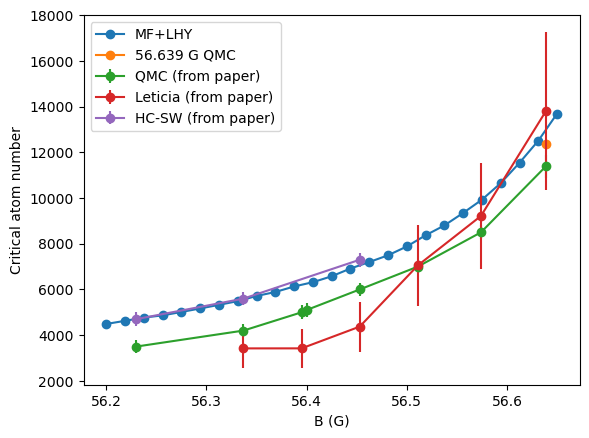

In [479]:
# set B_range to be between 56.2 and 56.65
B_range = np.linspace(56.2, 56.65, 25)
# For each point in the B_range, calculate the critical atom number 
nparticles = np.zeros_like(B_range)
en_0 = np.zeros_like(B_range)
for i, B in enumerate(B_range):
    # get alpha and beta
    alpha, beta = get_mflhy_params(interpolate_a11(B), interpolate_a22(B), interpolate_a12(B))    
    nparticles[i], en_0[i] = estimate_nc(alpha, beta, gamma, interpolate_a11(B), a_ho)
# Plot the critical atom number as a function of B  
plt.plot(B_range, nparticles, label="MF+LHY", marker='o')
# ylabel is "Critical atom number" and xlabel is "B (G)"
plt.ylabel("Critical atom number")
plt.xlabel("B (G)")




# Estimate the critical atom number for B=56.639. alpha and beta are the fits to the E/N vs rho (and using the sigma_en) from the file eos-files/eos_56.639.dat. rho is the 1st column, E/N is the 2nd column, and sigma_en is the 3rd column.
# load data from eos-files/eos_56.639.dat
data = np.loadtxt("eos-files/eos_56.639.dat")
rho = data[:,1]
en = data[:,2]
sigma_en = data[:,3]
print(f"rho: {rho}, en: {en}, sigma_en: {sigma_en}")
# get alpha and beta by fitting en vs rho. Use curve_fit and the function alpha*rho + beta*rho**gamma as the function to fit.
alpha, beta, gamma = curve_fit(lambda rho, alpha, beta, gamma: alpha*rho + beta*rho**gamma, rho, en, sigma=sigma_en,p0=[-2, 10, 1.5], maxfev=10000)[0]
print(f"[alpha, beta, gamma] = [{alpha}, {beta}, {gamma}]")
# estimate the critical atom number
nparticles, en_0 = estimate_nc(alpha, beta, gamma, interpolate_a11(56.639), a_ho)
print(f"Critical atom number: {nparticles}")
# put a point 56.639, nparticles on a plot
plt.plot(56.639, nparticles, marker='o', label="56.639 G QMC")



# Load data fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat from the ./data-from-paper/ folder
data_qmc = np.loadtxt("./data-from-paper/fig3a_qmc.dat")
data_let = np.loadtxt("./data-from-paper/fig3a_data_leticia.dat")
data_hcsw = np.loadtxt("./data-from-paper/fig3a_qmc_hcsw.dat")
# Plot the data from fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat. 0th column is B, 1st column is nparticles, 2nd column is error. In case of fig3a_data_leticia.dat, 2nd column is nparticles, 3rd column is error.
plt.errorbar(data_qmc[:,0], data_qmc[:,1], yerr=data_qmc[:,2], label="QMC (from paper)", marker='o')
plt.errorbar(data_let[:,0], data_let[:,2], yerr=data_let[:,3], label="Leticia (from paper)", marker='o')
plt.errorbar(data_hcsw[:,0], data_hcsw[:,1], yerr=data_hcsw[:,2], label="HC-SW (from paper)", marker='o')

plt.legend()

rho: [1.0e-05 4.0e-05 7.0e-05 1.0e-04 1.3e-04 1.6e-04 1.9e-04 2.2e-04 2.5e-04
 2.8e-04], en: [-1.912220e-06 -4.790903e-06 -5.494422e-06 -4.791246e-06 -2.332812e-06
  6.851999e-07  4.142386e-06  8.823350e-06  1.431579e-05  2.057130e-05], sigma_en: [7.302391e-09 2.218317e-08 4.880287e-08 7.673218e-08 9.137258e-08
 1.218352e-07 1.481580e-07 1.492576e-07 1.980993e-07 1.781040e-07]
[alpha, beta, gamma] = [-0.29458813390485494, 8.358704437722825, 1.3817913235720531]
Critical atom number: 8891.597621976243


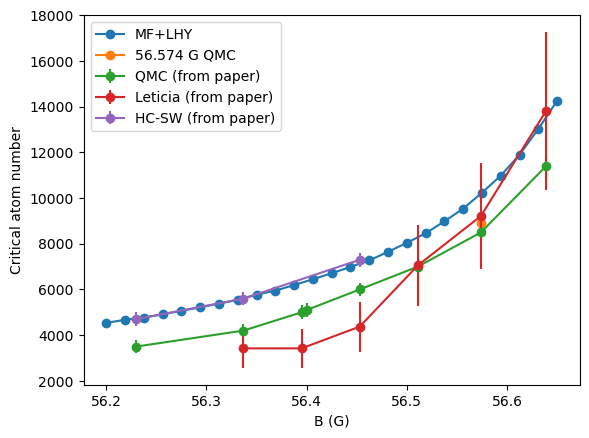

In [480]:
# set B_range to be between 56.2 and 56.65
B_range = np.linspace(56.2, 56.65, 25)
# For each point in the B_range, calculate the critical atom number 
nparticles = np.zeros_like(B_range)
en_0 = np.zeros_like(B_range)
for i, B in enumerate(B_range):
    # get alpha and beta
    alpha, beta = get_mflhy_params(interpolate_a11(B), interpolate_a22(B), interpolate_a12(B))    
    nparticles[i], en_0[i] = estimate_nc(alpha, beta, gamma, interpolate_a11(B), a_ho)
# Plot the critical atom number as a function of B  
plt.plot(B_range, nparticles, label="MF+LHY", marker='o')
# ylabel is "Critical atom number" and xlabel is "B (G)"
plt.ylabel("Critical atom number")
plt.xlabel("B (G)")




# Estimate the critical atom number for B=56.574. alpha and beta are the fits to the E/N vs rho (and using the sigma_en) from the file eos-files/eos_56.574.dat. rho is the 1st column, E/N is the 2nd column, and sigma_en is the 3rd column.
# load data from eos-files/eos_56.574.dat
data = np.loadtxt("eos-files/eos_56.574.dat")
rho = data[:,1]
en = data[:,2]
sigma_en = data[:,3]
print(f"rho: {rho}, en: {en}, sigma_en: {sigma_en}")
# get alpha and beta by fitting en vs rho. Use curve_fit and the function alpha*rho + beta*rho**gamma as the function to fit.
alpha, beta, gamma = curve_fit(lambda rho, alpha, beta, gamma: alpha*rho + beta*rho**gamma, rho, en, sigma=sigma_en,p0=[-2, 10, 1.5], maxfev=10000)[0]
print(f"[alpha, beta, gamma] = [{alpha}, {beta}, {gamma}]")
# estimate the critical atom number
nparticles, en_0 = estimate_nc(alpha, beta, gamma, interpolate_a11(56.574), a_ho)
print(f"Critical atom number: {nparticles}")
# put a point 56.574, nparticles on a plot
plt.plot(56.574, nparticles, marker='o', label="56.574 G QMC")



# Load data fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat from the ./data-from-paper/ folder
data_qmc = np.loadtxt("./data-from-paper/fig3a_qmc.dat")
data_let = np.loadtxt("./data-from-paper/fig3a_data_leticia.dat")
data_hcsw = np.loadtxt("./data-from-paper/fig3a_qmc_hcsw.dat")
# Plot the data from fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat. 0th column is B, 1st column is nparticles, 2nd column is error. In case of fig3a_data_leticia.dat, 2nd column is nparticles, 3rd column is error.
plt.errorbar(data_qmc[:,0], data_qmc[:,1], yerr=data_qmc[:,2], label="QMC (from paper)", marker='o')
plt.errorbar(data_let[:,0], data_let[:,2], yerr=data_let[:,3], label="Leticia (from paper)", marker='o')
plt.errorbar(data_hcsw[:,0], data_hcsw[:,1], yerr=data_hcsw[:,2], label="HC-SW (from paper)", marker='o')

plt.legend()

rho: [1.0e-05 4.0e-05 7.0e-05 1.0e-04 1.3e-04 1.6e-04 1.9e-04 2.2e-04 2.5e-04
 2.8e-04], en: [-1.912220e-06 -4.790903e-06 -5.494422e-06 -4.791246e-06 -2.332812e-06
  6.851999e-07  4.142386e-06  8.823350e-06  1.431579e-05  2.057130e-05], sigma_en: [7.302391e-09 2.218317e-08 4.880287e-08 7.673218e-08 9.137258e-08
 1.218352e-07 1.481580e-07 1.492576e-07 1.980993e-07 1.781040e-07]
[alpha, beta, gamma] = [-0.29458813390485494, 8.358704437722825, 1.3817913235720531]
Critical atom number: 8891.597621976243


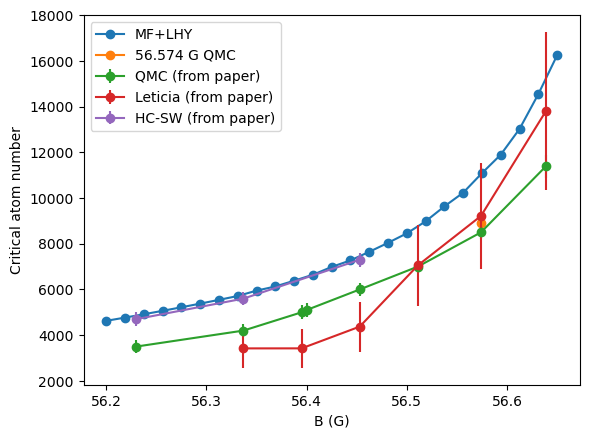

In [481]:
# set B_range to be between 56.2 and 56.65
B_range = np.linspace(56.2, 56.65, 25)
# For each point in the B_range, calculate the critical atom number 
nparticles = np.zeros_like(B_range)
en_0 = np.zeros_like(B_range)
for i, B in enumerate(B_range):
    # get alpha and beta
    alpha, beta = get_mflhy_params(interpolate_a11(B), interpolate_a22(B), interpolate_a12(B))    
    nparticles[i], en_0[i] = estimate_nc(alpha, beta, gamma, interpolate_a11(B), a_ho)
# Plot the critical atom number as a function of B  
plt.plot(B_range, nparticles, label="MF+LHY", marker='o')
# ylabel is "Critical atom number" and xlabel is "B (G)"
plt.ylabel("Critical atom number")
plt.xlabel("B (G)")




# Estimate the critical atom number for B=56.574. alpha and beta are the fits to the E/N vs rho (and using the sigma_en) from the file eos-files/eos_56.574.dat. rho is the 1st column, E/N is the 2nd column, and sigma_en is the 3rd column.
# load data from eos-files/eos_56.574.dat
data = np.loadtxt("eos-files/eos_56.574.dat")
rho = data[:,1]
en = data[:,2]
sigma_en = data[:,3]
print(f"rho: {rho}, en: {en}, sigma_en: {sigma_en}")
# get alpha and beta by fitting en vs rho. Use curve_fit and the function alpha*rho + beta*rho**gamma as the function to fit.
alpha, beta, gamma = curve_fit(lambda rho, alpha, beta, gamma: alpha*rho + beta*rho**gamma, rho, en, sigma=sigma_en,p0=[-2, 10, 1.5], maxfev=10000)[0]
print(f"[alpha, beta, gamma] = [{alpha}, {beta}, {gamma}]")
# estimate the critical atom number
nparticles, en_0 = estimate_nc(alpha, beta, gamma, interpolate_a11(56.574), a_ho)
print(f"Critical atom number: {nparticles}")
# put a point 56.574, nparticles on a plot
plt.plot(56.574, nparticles, marker='o', label="56.574 G QMC")



# Load data fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat from the ./data-from-paper/ folder
data_qmc = np.loadtxt("./data-from-paper/fig3a_qmc.dat")
data_let = np.loadtxt("./data-from-paper/fig3a_data_leticia.dat")
data_hcsw = np.loadtxt("./data-from-paper/fig3a_qmc_hcsw.dat")
# Plot the data from fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat. 0th column is B, 1st column is nparticles, 2nd column is error. In case of fig3a_data_leticia.dat, 2nd column is nparticles, 3rd column is error.
plt.errorbar(data_qmc[:,0], data_qmc[:,1], yerr=data_qmc[:,2], label="QMC (from paper)", marker='o')
plt.errorbar(data_let[:,0], data_let[:,2], yerr=data_let[:,3], label="Leticia (from paper)", marker='o')
plt.errorbar(data_hcsw[:,0], data_hcsw[:,1], yerr=data_hcsw[:,2], label="HC-SW (from paper)", marker='o')

plt.legend()

# All the eos files

[INFO] B_file: 56.453
[INFO] B_file: 56.511
[INFO] B_file: 56.23
[INFO] B_file: 56.395
[INFO] B_file: 56.337
[INFO] B_file: 56.337
[INFO] B_file: 56.574
[INFO] B_file: 56.337
[INFO] B_file: 56.337
[INFO] B_file: 56.639
[INFO] B_file: 56.337
[INFO] B_file: 56.337
[INFO] B_file: 56.337
[INFO] B_file: 56.453


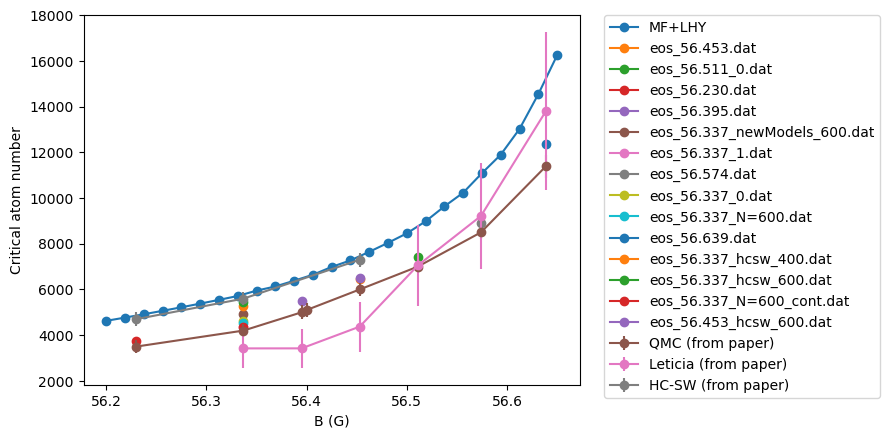

In [482]:
# set B_range to be between 56.2 and 56.65
B_range = np.linspace(56.2, 56.65, 25)
# For each point in the B_range, calculate the critical atom number 
nparticles = np.zeros_like(B_range)
en_0 = np.zeros_like(B_range)
for i, B in enumerate(B_range):
    # get alpha and beta
    alpha, beta = get_mflhy_params(interpolate_a11(B), interpolate_a22(B), interpolate_a12(B))    
    nparticles[i], en_0[i] = estimate_nc(alpha, beta, gamma, interpolate_a11(B), a_ho, verbose=False)
# Plot the critical atom number as a function of B  
plt.plot(B_range, nparticles, label="MF+LHY", marker='o')
# ylabel is "Critical atom number" and xlabel is "B (G)"
plt.ylabel("Critical atom number")
plt.xlabel("B (G)")



# list all files in eos-files/ folder
eos_files = os.listdir("eos-files/")
# For each file in eos-files/ folder, load the data and plot the critical atom number as a function of B. Label is the file name.
for eos_file in eos_files:
    data = np.loadtxt(f"eos-files/{eos_file}")
    # get B from the file name. eos_file is something like eos_56.337_N=600.dat or eos_56.337.dat. B is 56.337
    B_file = float(eos_file.split("_")[1].replace(".dat", ""))
    print(f"[INFO] B_file: {B_file}")
    
    
    # Check if the data has 4 columns. If it does, then the 4th column is the error in the energy per particle. If it doesn't, then there is no error in the energy per particle.
    if data.shape[1] == 4:
        rho = data[:,1]
        en = data[:,2]
        sigma_en = data[:,3]
    else:
        rho = data[:,0]
        en = data[:,1]
        sigma_en = data[:,2]
    alpha, beta, gamma = curve_fit(lambda rho, alpha, beta, gamma: alpha*rho + beta*rho**gamma, rho, en, sigma=sigma_en,p0=[-2, 10, 1.5], maxfev=10000)[0]
    nparticles, en_0 = estimate_nc(alpha, beta, gamma, interpolate_a11(B_file), a_ho, verbose=False)
    plt.plot(B_file, nparticles, marker='o', label=eos_file)


# Load data fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat from the ./data-from-paper/ folder
data_qmc = np.loadtxt("./data-from-paper/fig3a_qmc.dat")
data_let = np.loadtxt("./data-from-paper/fig3a_data_leticia.dat")
data_hcsw = np.loadtxt("./data-from-paper/fig3a_qmc_hcsw.dat")
# Plot the data from fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat. 0th column is B, 1st column is nparticles, 2nd column is error. In case of fig3a_data_leticia.dat, 2nd column is nparticles, 3rd column is error.
plt.errorbar(data_qmc[:,0], data_qmc[:,1], yerr=data_qmc[:,2], label="QMC (from paper)", marker='o')
plt.errorbar(data_let[:,0], data_let[:,2], yerr=data_let[:,3], label="Leticia (from paper)", marker='o')
plt.errorbar(data_hcsw[:,0], data_hcsw[:,1], yerr=data_hcsw[:,2], label="HC-SW (from paper)", marker='o')

# put legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# analyze onle B=56.337

[INFO] B_file: 56.453
[INFO] B_file: 56.511
[INFO] B_file: 56.23
[INFO] B_file: 56.395
[INFO] B_file: 56.337
[INFO] B_file: 56.337
[INFO] B_file: 56.574
[INFO] B_file: 56.337
[INFO] B_file: 56.337
[INFO] B_file: 56.639
[INFO] B_file: 56.337
[INFO] B_file: 56.337
[INFO] B_file: 56.337
[INFO] B_file: 56.453


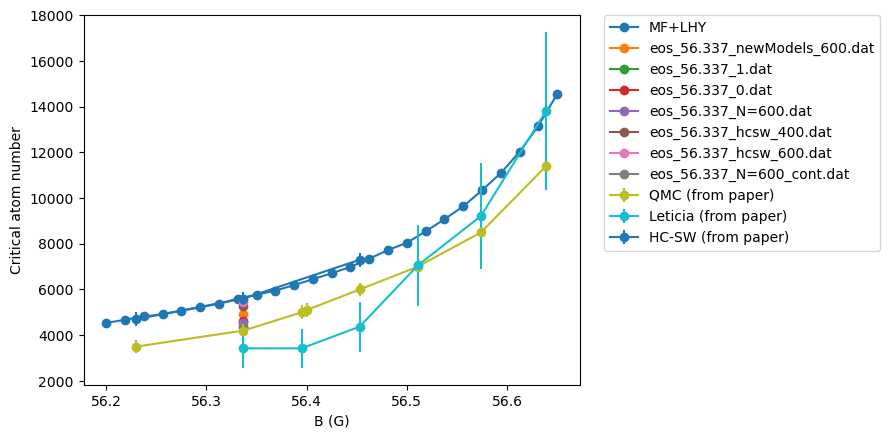

In [483]:
# set B_range to be between 56.2 and 56.65
B_range = np.linspace(56.2, 56.65, 25)
# For each point in the B_range, calculate the critical atom number 
nparticles = np.zeros_like(B_range)
en_0 = np.zeros_like(B_range)
for i, B in enumerate(B_range):
    # get alpha and beta
    alpha, beta = get_mflhy_params(interpolate_a11(B), interpolate_a22(B), interpolate_a12(B))    
    nparticles[i], en_0[i] = estimate_nc(alpha, beta, gamma, interpolate_a11(B), a_ho, verbose=False)
# Plot the critical atom number as a function of B  
plt.plot(B_range, nparticles, label="MF+LHY", marker='o')
# ylabel is "Critical atom number" and xlabel is "B (G)"
plt.ylabel("Critical atom number")
plt.xlabel("B (G)")



# list all files in eos-files/ folder
eos_files = os.listdir("eos-files/")
# For each file in eos-files/ folder, load the data and plot the critical atom number as a function of B. Label is the file name.
for eos_file in eos_files:
    data = np.loadtxt(f"eos-files/{eos_file}")
    # get B from the file name. eos_file is something like eos_56.337_N=600.dat or eos_56.337.dat. B is 56.337
    B_file = float(eos_file.split("_")[1].replace(".dat", ""))
    print(f"[INFO] B_file: {B_file}")
    
    # don't continue if B_file is not 56.337
    if B_file != 56.337:
        continue
    
    # Check if the data has 4 columns. If it does, then the 4th column is the error in the energy per particle. If it doesn't, then there is no error in the energy per particle.
    if data.shape[1] == 4:
        rho = data[:,1]
        en = data[:,2]
        sigma_en = data[:,3]
    else:
        rho = data[:,0]
        en = data[:,1]
        sigma_en = data[:,2]
    alpha, beta, gamma = curve_fit(lambda rho, alpha, beta, gamma: alpha*rho + beta*rho**gamma, rho, en, sigma=sigma_en,p0=[-2, 10, 1.5], maxfev=10000)[0]
    nparticles, en_0 = estimate_nc(alpha, beta, gamma, interpolate_a11(B_file), a_ho, verbose=False)
    plt.plot(B_file, nparticles, marker='o', label=eos_file)


# Load data fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat from the ./data-from-paper/ folder
data_qmc = np.loadtxt("./data-from-paper/fig3a_qmc.dat")
data_let = np.loadtxt("./data-from-paper/fig3a_data_leticia.dat")
data_hcsw = np.loadtxt("./data-from-paper/fig3a_qmc_hcsw.dat")
# Plot the data from fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat. 0th column is B, 1st column is nparticles, 2nd column is error. In case of fig3a_data_leticia.dat, 2nd column is nparticles, 3rd column is error.
plt.errorbar(data_qmc[:,0], data_qmc[:,1], yerr=data_qmc[:,2], label="QMC (from paper)", marker='o')
plt.errorbar(data_let[:,0], data_let[:,2], yerr=data_let[:,3], label="Leticia (from paper)", marker='o')
plt.errorbar(data_hcsw[:,0], data_hcsw[:,1], yerr=data_hcsw[:,2], label="HC-SW (from paper)", marker='o')

# put legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# DEBUG individual eos files

rho: [1.0e-05 5.0e-05 9.0e-05 1.3e-04 1.7e-04 2.1e-04 2.5e-04 2.9e-04 3.3e-04
 3.7e-04 4.1e-04 4.5e-04 4.9e-04], en: [-3.059119e-06 -1.061712e-05 -1.423877e-05 -1.550080e-05 -1.481893e-05
 -1.259269e-05 -7.958130e-06 -3.535141e-06  2.667901e-06  1.029003e-05
  1.776216e-05  2.705955e-05  3.612002e-05], sigma_en: [5.508857e-09 4.880621e-08 7.334443e-08 1.045180e-07 1.625481e-07
 2.442217e-07 2.147191e-07 2.186084e-07 3.118873e-07 2.725402e-07
 2.817185e-07 3.863453e-07 4.792050e-07]
[alpha, beta, gamma] = [-0.42346129126579685, 8.549090328359902, 1.3726369693418652]
Critical atom number: 6446.233431182386


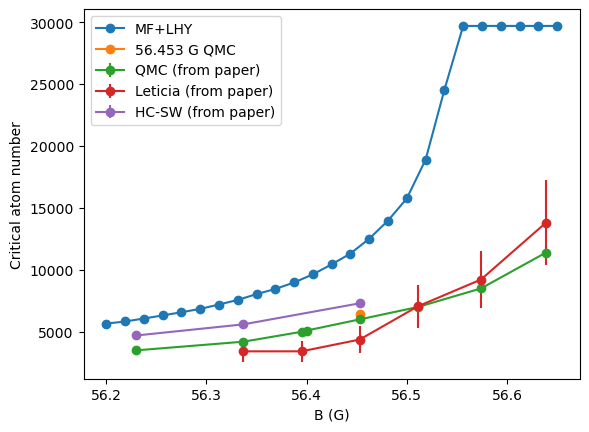

In [484]:
# set B_range to be between 56.2 and 56.65
B_range = np.linspace(56.2, 56.65, 25)
# For each point in the B_range, calculate the critical atom number 
nparticles = np.zeros_like(B_range)
en_0 = np.zeros_like(B_range)
for i, B in enumerate(B_range):
    # get alpha and beta
    alpha, beta = get_mflhy_params(interpolate_a11(B), interpolate_a22(B), interpolate_a12(B))    
    nparticles[i], en_0[i] = estimate_nc(alpha, beta, gamma, interpolate_a11(B), a_ho)
# Plot the critical atom number as a function of B  
plt.plot(B_range, nparticles, label="MF+LHY", marker='o')
# ylabel is "Critical atom number" and xlabel is "B (G)"
plt.ylabel("Critical atom number")
plt.xlabel("B (G)")




# Estimate the critical atom number for B=56.453. alpha and beta are the fits to the E/N vs rho (and using the sigma_en) from the file eos-files/eos_56.453.dat. rho is the 1st column, E/N is the 2nd column, and sigma_en is the 3rd column.
# load data from eos-files/eos_56.453.dat
data = np.loadtxt("eos-files/eos_56.453.dat")
rho = data[:,1]
en = data[:,2]
sigma_en = data[:,3]
print(f"rho: {rho}, en: {en}, sigma_en: {sigma_en}")
# get alpha and beta by fitting en vs rho. Use curve_fit and the function alpha*rho + beta*rho**gamma as the function to fit.
alpha, beta, gamma = curve_fit(lambda rho, alpha, beta, gamma: alpha*rho + beta*rho**gamma, rho, en, sigma=sigma_en,p0=[-2, 10, 1.5], maxfev=10000)[0]
print(f"[alpha, beta, gamma] = [{alpha}, {beta}, {gamma}]")
# estimate the critical atom number
nparticles, en_0 = estimate_nc(alpha, beta, gamma, interpolate_a11(56.453), a_ho)
print(f"Critical atom number: {nparticles}")
# put a point 56.453, nparticles on a plot
plt.plot(56.453, nparticles, marker='o', label="56.453 G QMC")



# Load data fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat from the ./data-from-paper/ folder
data_qmc = np.loadtxt("./data-from-paper/fig3a_qmc.dat")
data_let = np.loadtxt("./data-from-paper/fig3a_data_leticia.dat")
data_hcsw = np.loadtxt("./data-from-paper/fig3a_qmc_hcsw.dat")
# Plot the data from fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat. 0th column is B, 1st column is nparticles, 2nd column is error. In case of fig3a_data_leticia.dat, 2nd column is nparticles, 3rd column is error.
plt.errorbar(data_qmc[:,0], data_qmc[:,1], yerr=data_qmc[:,2], label="QMC (from paper)", marker='o')
plt.errorbar(data_let[:,0], data_let[:,2], yerr=data_let[:,3], label="Leticia (from paper)", marker='o')
plt.errorbar(data_hcsw[:,0], data_hcsw[:,1], yerr=data_hcsw[:,2], label="HC-SW (from paper)", marker='o')

plt.legend()

rho: [5.0e-05 1.0e-04 1.5e-04 2.0e-04 2.5e-04 3.0e-04 3.5e-04 4.0e-04 4.5e-04
 5.0e-04], en: [-1.321972e-05 -1.997190e-05 -2.252781e-05 -2.265560e-05 -1.990825e-05
 -1.498252e-05 -8.997011e-06 -1.825718e-06  8.370780e-06  1.869025e-05], sigma_en: [5.521904e-08 1.014836e-07 1.304618e-07 2.251799e-07 2.130056e-07
 2.948702e-07 2.974265e-07 3.441456e-07 3.525483e-07 3.770746e-07]
[alpha, beta, gamma] = [-0.5133791214690759, 7.7011470615888955, 1.3469313002796934]
Critical atom number: 5488.695549271827


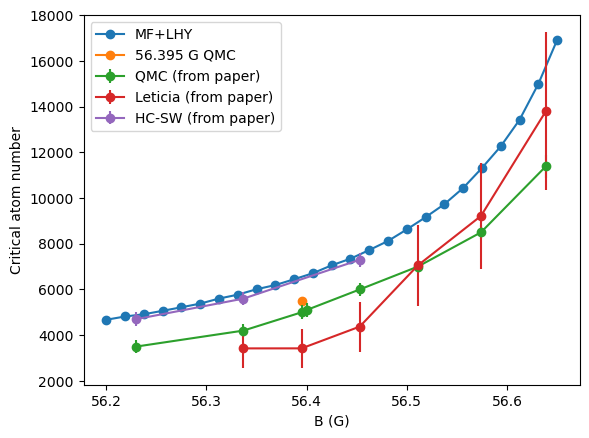

In [485]:
# set B_range to be between 56.2 and 56.65
B_range = np.linspace(56.2, 56.65, 25)
# For each point in the B_range, calculate the critical atom number 
nparticles = np.zeros_like(B_range)
en_0 = np.zeros_like(B_range)
for i, B in enumerate(B_range):
    # get alpha and beta
    alpha, beta = get_mflhy_params(interpolate_a11(B), interpolate_a22(B), interpolate_a12(B))    
    nparticles[i], en_0[i] = estimate_nc(alpha, beta, gamma, interpolate_a11(B), a_ho)
# Plot the critical atom number as a function of B  
plt.plot(B_range, nparticles, label="MF+LHY", marker='o')
# ylabel is "Critical atom number" and xlabel is "B (G)"
plt.ylabel("Critical atom number")
plt.xlabel("B (G)")




# Estimate the critical atom number for B=56.395. alpha and beta are the fits to the E/N vs rho (and using the sigma_en) from the file eos-files/eos_56.395.dat. rho is the 1st column, E/N is the 2nd column, and sigma_en is the 3rd column.
# load data from eos-files/eos_56.395.dat
data = np.loadtxt("eos-files/eos_56.395.dat")
rho = data[:,1]
en = data[:,2]
sigma_en = data[:,3]
print(f"rho: {rho}, en: {en}, sigma_en: {sigma_en}")
# get alpha and beta by fitting en vs rho. Use curve_fit and the function alpha*rho + beta*rho**gamma as the function to fit.
alpha, beta, gamma = curve_fit(lambda rho, alpha, beta, gamma: alpha*rho + beta*rho**gamma, rho, en, sigma=sigma_en,p0=[-2, 10, 1.5], maxfev=10000)[0]
print(f"[alpha, beta, gamma] = [{alpha}, {beta}, {gamma}]")
# estimate the critical atom number
nparticles, en_0 = estimate_nc(alpha, beta, gamma, interpolate_a11(56.395), a_ho)
print(f"Critical atom number: {nparticles}")
# put a point 56.395, nparticles on a plot
plt.plot(56.395, nparticles, marker='o', label="56.395 G QMC")



# Load data fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat from the ./data-from-paper/ folder
data_qmc = np.loadtxt("./data-from-paper/fig3a_qmc.dat")
data_let = np.loadtxt("./data-from-paper/fig3a_data_leticia.dat")
data_hcsw = np.loadtxt("./data-from-paper/fig3a_qmc_hcsw.dat")
# Plot the data from fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat. 0th column is B, 1st column is nparticles, 2nd column is error. In case of fig3a_data_leticia.dat, 2nd column is nparticles, 3rd column is error.
plt.errorbar(data_qmc[:,0], data_qmc[:,1], yerr=data_qmc[:,2], label="QMC (from paper)", marker='o')
plt.errorbar(data_let[:,0], data_let[:,2], yerr=data_let[:,3], label="Leticia (from paper)", marker='o')
plt.errorbar(data_hcsw[:,0], data_hcsw[:,1], yerr=data_hcsw[:,2], label="HC-SW (from paper)", marker='o')

plt.legend()

rho: [0.0001  0.0002  0.0003  0.0004  0.0005  0.0006  0.00015 0.00025 0.00035
 0.00045 0.00055 0.00065], en: [-2.475398e-05 -3.160249e-05 -2.803647e-05 -1.877452e-05 -2.357544e-06
  1.901992e-05 -2.975219e-05 -3.050468e-05 -2.447067e-05 -1.060193e-05
  8.062362e-06  3.148186e-05], sigma_en: [1.290382e-07 8.924866e-08 2.345013e-07 3.490551e-07 3.918116e-07
 5.566430e-07 1.030071e-07 2.301691e-07 3.230189e-07 4.001290e-07
 4.069044e-07 5.430222e-07]
[alpha, beta, gamma] = [-0.6406689827011071, 6.281198151103806, 1.3011888601348078]
Critical atom number: 4534.5880485944135


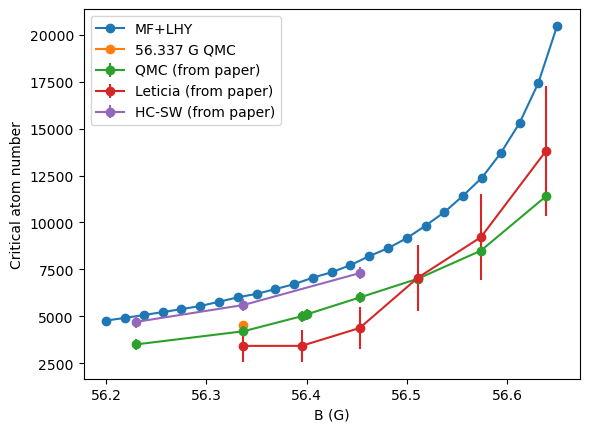

In [486]:
# set B_range to be between 56.2 and 56.65
B_range = np.linspace(56.2, 56.65, 25)
# For each point in the B_range, calculate the critical atom number 
nparticles = np.zeros_like(B_range)
en_0 = np.zeros_like(B_range)
for i, B in enumerate(B_range):
    # get alpha and beta
    alpha, beta = get_mflhy_params(interpolate_a11(B), interpolate_a22(B), interpolate_a12(B))    
    nparticles[i], en_0[i] = estimate_nc(alpha, beta, gamma, interpolate_a11(B), a_ho)
# Plot the critical atom number as a function of B  
plt.plot(B_range, nparticles, label="MF+LHY", marker='o')
# ylabel is "Critical atom number" and xlabel is "B (G)"
plt.ylabel("Critical atom number")
plt.xlabel("B (G)")




# Estimate the critical atom number for B=56.337. alpha and beta are the fits to the E/N vs rho (and using the sigma_en) from the file eos-files/eos_56.337.dat. rho is the 1st column, E/N is the 2nd column, and sigma_en is the 3rd column.
# load data from eos-files/eos_56.337.dat
data = np.loadtxt("eos-files/eos_56.337_N=600.dat")
rho = data[:,1]
en = data[:,2]
sigma_en = data[:,3]
print(f"rho: {rho}, en: {en}, sigma_en: {sigma_en}")
# get alpha and beta by fitting en vs rho. Use curve_fit and the function alpha*rho + beta*rho**gamma as the function to fit.
alpha, beta, gamma = curve_fit(lambda rho, alpha, beta, gamma: alpha*rho + beta*rho**gamma, rho, en, sigma=sigma_en,p0=[-2, 10, 1.5], maxfev=10000)[0]
print(f"[alpha, beta, gamma] = [{alpha}, {beta}, {gamma}]")
# estimate the critical atom number
nparticles, en_0 = estimate_nc(alpha, beta, gamma, interpolate_a11(56.337), a_ho)
print(f"Critical atom number: {nparticles}")
# put a point 56.337, nparticles on a plot
plt.plot(56.337, nparticles, marker='o', label="56.337 G QMC")



# Load data fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat from the ./data-from-paper/ folder
data_qmc = np.loadtxt("./data-from-paper/fig3a_qmc.dat")
data_let = np.loadtxt("./data-from-paper/fig3a_data_leticia.dat")
data_hcsw = np.loadtxt("./data-from-paper/fig3a_qmc_hcsw.dat")
# Plot the data from fig3a_qmc.dat, fig3a_data_leticia.dat, fig3a_qmc_hcsw.dat. 0th column is B, 1st column is nparticles, 2nd column is error. In case of fig3a_data_leticia.dat, 2nd column is nparticles, 3rd column is error.
plt.errorbar(data_qmc[:,0], data_qmc[:,1], yerr=data_qmc[:,2], label="QMC (from paper)", marker='o')
plt.errorbar(data_let[:,0], data_let[:,2], yerr=data_let[:,3], label="Leticia (from paper)", marker='o')
plt.errorbar(data_hcsw[:,0], data_hcsw[:,1], yerr=data_hcsw[:,2], label="HC-SW (from paper)", marker='o')

plt.legend()

# DEBUG

In [487]:
# Estimate the critical atom number for B=56.639. alpha and beta are the fits to the E/N vs rho (and using the sigma_en) from the file eos-files/eos_56.639.dat. rho is the 1st column, E/N is the 2nd column, and sigma_en is the 3rd column.
# load data from eos-files/eos_56.639.dat
data = np.loadtxt("eos-files/eos_56.639.dat")
rho = data[:,1]
en = data[:,2]
sigma_en = data[:,3]
print(f"rho: {rho}, en: {en}, sigma_en: {sigma_en}")
# get alpha and beta by fitting en vs rho. Use curve_fit and the function alpha*rho + beta*rho**gamma as the function to fit.
alpha, beta, gamma = curve_fit(lambda rho, alpha, beta, gamma: alpha*rho + beta*rho**gamma, rho, en, sigma=sigma_en, maxfev=10000)[0]
print(f"[alpha, beta, gamma] = [{alpha}, {beta}, {gamma}]")
# estimate the critical atom number
nparticles, en_0 = estimate_nc(alpha, beta, gamma, interpolate_a11(56.639), a_ho)
print(f"Critical atom number: {nparticles}")
# put the critical atom number on the plot
plt.text(56.639, nparticles, f"{nparticles:.2f}", horizontalalignment='center', verticalalignment='center')

rho: [1.e-05 2.e-05 3.e-05 4.e-05 5.e-05 6.e-05 7.e-05 8.e-05 9.e-05 1.e-04], en: [-1.260085e-06 -1.968730e-06 -2.371282e-06 -2.462690e-06 -2.382239e-06
 -2.036552e-06 -1.548057e-06 -8.673761e-07 -1.244487e-07  7.746036e-07], sigma_en: [5.058807e-09 7.422552e-09 1.302559e-08 1.511843e-08 1.970012e-08
 2.844823e-08 2.198545e-08 1.590390e-08 2.195948e-08 4.582702e-08]
[alpha, beta, gamma] = [586.7025792724106, -586.1325223828118, 0.9998947873114261]
Critical atom number: 4312.348114608746


Text(56.639, 4312.348114608746, '4312.35')

ValueError: Image size of 28173x1593894 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>